In [110]:
%reload_ext autoreload
%autoreload 2

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from src import const
import src.simulation.water_demands as wd
import src.utils.plot_utils as pu

_ = pu.setup_mpl(as_default=0)

Path.cwd()

PosixPath('/Users/adamzh0u/315_RL/cege_test')

## Test award function and distribution

In [111]:
dft2 = wd.load(243, 12)

In [112]:
dft2['Timestamp'] = pd.to_datetime(dft2['Timestamp'])
dft2['hour'] = dft2['Timestamp'].dt.hour

traffic_flow = np.array([20,15,10,10,10,20,
                        30,50,70,100, 90,80, 
                        60,55,50,50,60,90,
                        95,70,60,40,30,20
                        ])
dft2['TrafficFlow'] = traffic_flow[dft2['hour'].values]

# downtime_cost : rolling following 1 hour
dft2['a_downtime_award'] = -dft2['WaterDemandWithLeaks'].rolling(window=4).sum().shift(-3)
dft2['a_congestion_award'] = -dft2['TrafficFlow']*0.15
dft2['a_environmental_award'] = -np.log1p(dft2['LeakageLabel'].rolling(window=12).sum())
dft2['a_fix_award'] =  np.log1p(dft2['LeakageLabel'].rolling(window=12).sum().shift(-11).sum())
dft2['a_total_award'] = 8 + dft2['a_downtime_award'] + dft2['a_congestion_award'] + dft2['a_environmental_award'] + dft2['a_fix_award']

dft2['n_leakage_award'] = -dft2['WaterDemandWithLeaks'].rolling(window=12).sum().shift(-11)
dft2['n_environmental_award'] = -np.log1p(dft2['LeakageLabel'].rolling(window=7*24*4).sum())
dft2['n_total_award'] = dft2['n_leakage_award'] + dft2['n_environmental_award'] - 8

# mean fill na
dft2.fillna(dft2.mean(), inplace=True)

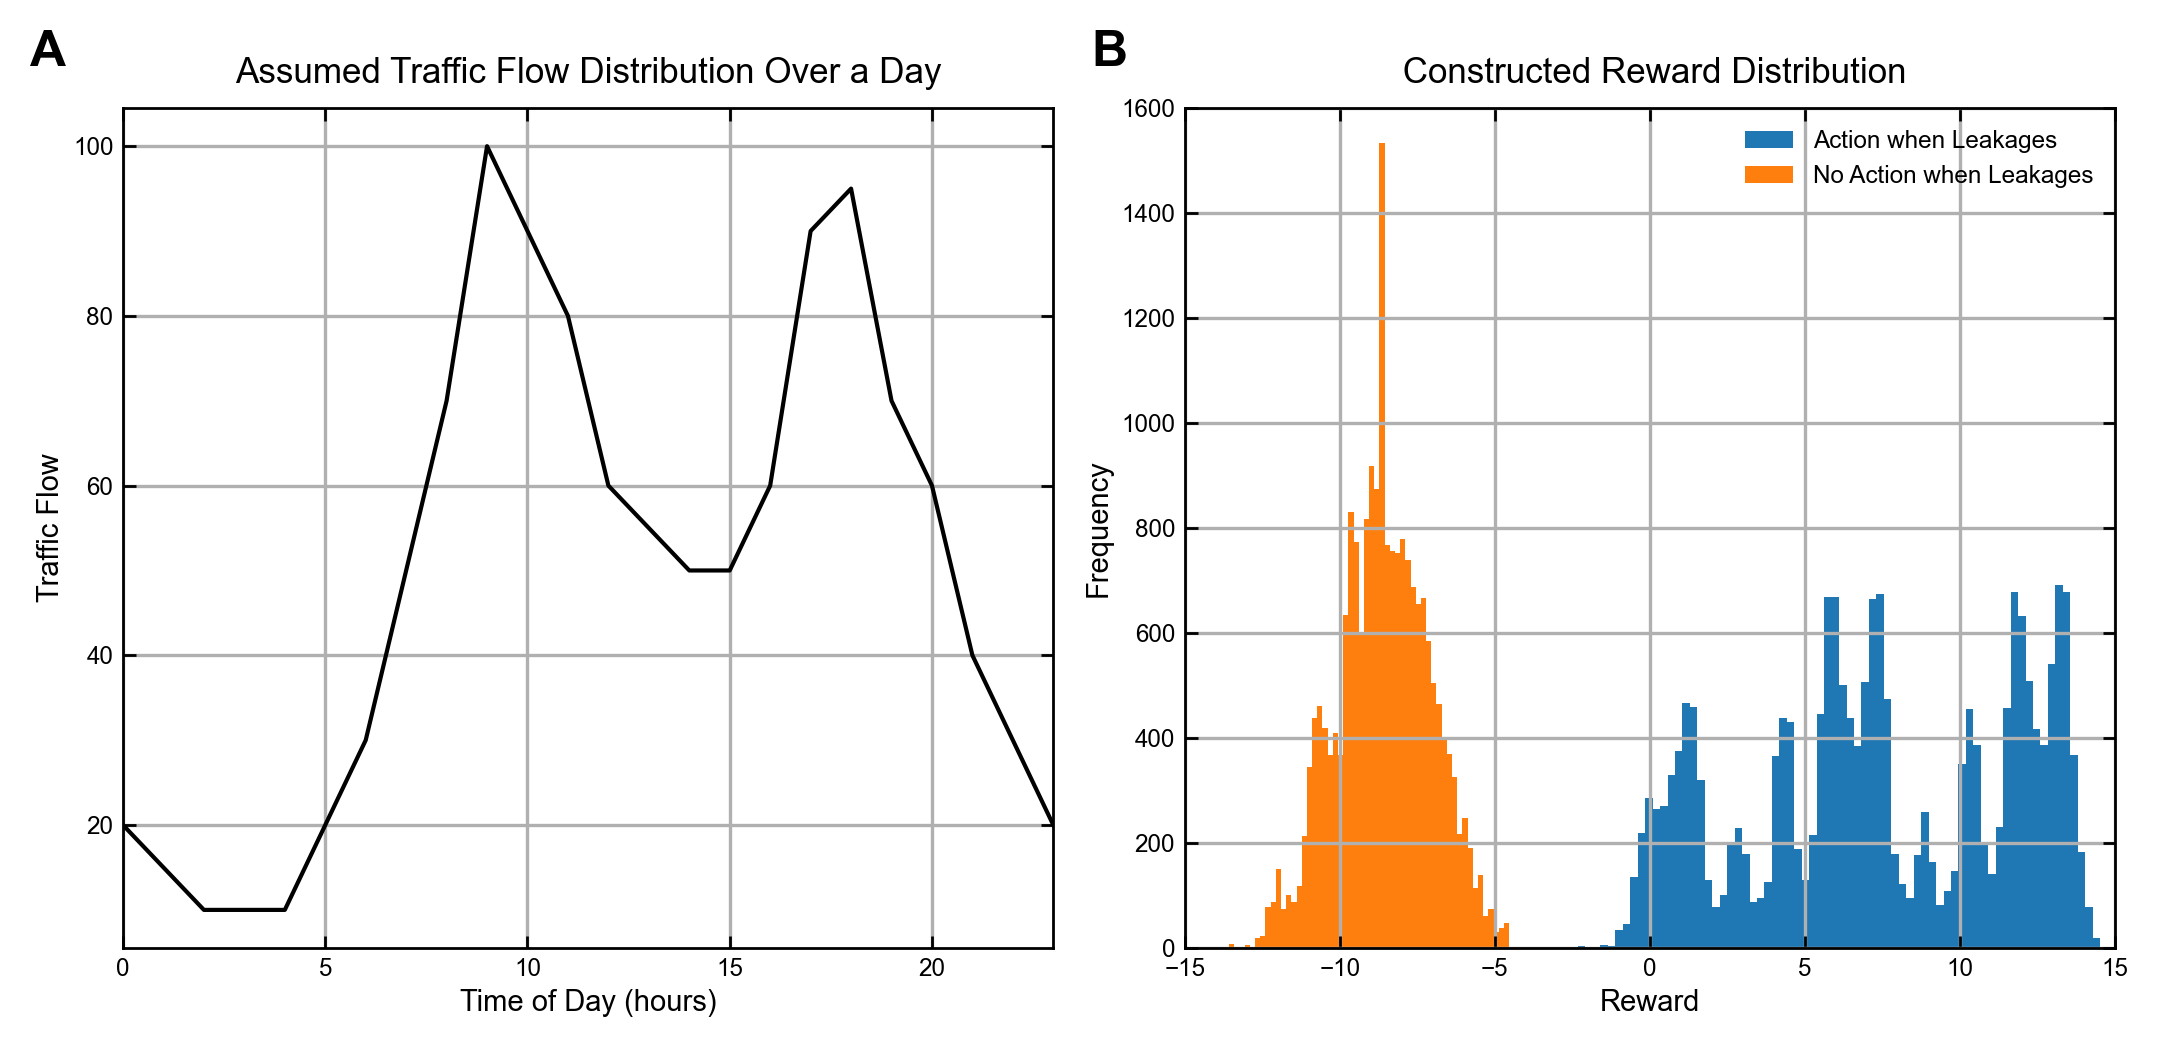

In [113]:
fig, ax = plt.subplots(1,2, figsize=(3.602361*2, 3.5),dpi=300)
time = np.arange(0, 24, 1)
ax[0].plot(time, traffic_flow, label='Traffic Flow', color='black')
ax[0].set_xlabel('Time of Day (hours)')
ax[0].set_ylabel('Traffic Flow')
ax[0].set_title('Assumed Traffic Flow Distribution Over a Day')
ax[0].grid(True)
ax[0].set_xlim(0, 23)

ax[1].grid(True)
ax[1].hist(dft2['a_total_award'], bins=80, label='Action when Leakages')

ax[1].hist(dft2['n_total_award'], bins=80, label='No Action when Leakages')
ax[1].set_title(' Constructed Reward Distribution') # 构建的奖励函数

# ax.set_yscale('log')
ax[1].set_xlabel('Reward')
ax[1].set_ylabel('Frequency')
ax[1].legend(frameon=False)
ax[1].set_xlim(-15, 15)
ax[1].set_ylim(0, 1600)
for i in range(2):
    # label A B 
    ax[i].text(-0.1, 1.05, chr(65+i), transform=ax[i].transAxes,
            size=12, weight='bold')

# save 
fig.savefig('figs/award_distribution.png')

## Test EnvComplexR

In [114]:
import src.env.env_basic as env_basic
import src.simulation.water_demands as wd

dft = wd.load(243, 12)

env = env_basic.EnvComplexR(dft)
env.reset()


(array([-0.01928942, -0.01883427,  0.00210519, -0.00350556,  0.00296355,
         0.0061122 , -0.03088086, -0.00671616,  0.00673889,  0.03825076]),
 {'step': 384})

In [115]:
for i in range(10000):
    r = env.step(0)[1]
    if r ==0.1:
        pass
    else:
        print(r)
        break

-9.18
